In [39]:
# импорты
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
import sklearn.covariance as cov
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from random import randint

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1798 entries, 0 to 378
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TVD      1798 non-null   float64
 1   GR       1798 non-null   float64
 2   WNKT     1798 non-null   float64
 3   DTP      1798 non-null   float64
 4   well_id  1798 non-null   object 
 5   DS_diff  835 non-null    float64
dtypes: float64(5), object(1)
memory usage: 98.3+ KB


In [4]:
df.head(5)

,TVD,GR,WNKT,DTP,well_id,DS_diff
0,842.031,10.257,40.069,343.124,UZ-12,NaN
1,842.130,9.947,40.314,339.601,UZ-12,NaN
2,842.228,9.366,40.060,340.717,UZ-12,NaN
3,842.327,8.050,38.385,331.685,UZ-12,NaN
4,842.426,6.654,34.709,308.736,UZ-12,NaN


In [5]:
df.drop(columns=['DS_diff'], inplace=True)

In [6]:
vec_func = np.vectorize(lambda x: int(x))
df['id'] = vec_func(np.cumsum(np.ones(len(df))) - 1)

In [7]:
metric_df = df.copy()
metric_df.set_index('id', inplace=True)
metric_df.drop(columns=['well_id', 'TVD'], inplace=True)
metric_df.head(5)

,GR,WNKT,DTP
id,,,
0,10.257,40.069,343.124
1,9.947,40.314,339.601
2,9.366,40.060,340.717
3,8.050,38.385,331.685
4,6.654,34.709,308.736


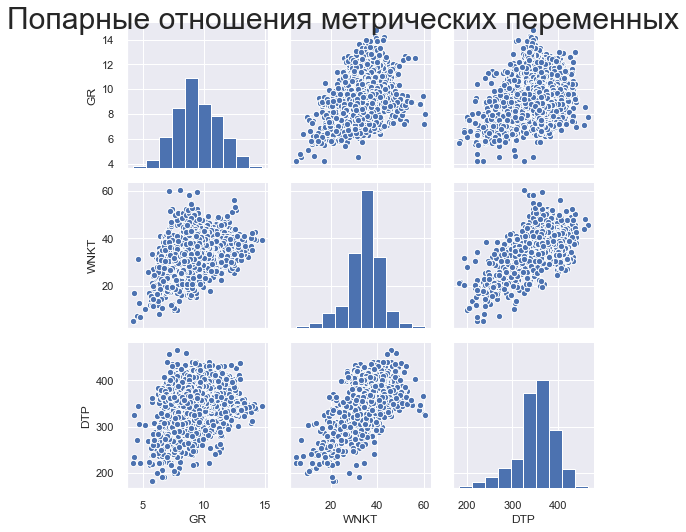

In [8]:
def pairwise_rel(data):
    sns.set()

    # Setting pairgrid
    g = sns.PairGrid(data)

    # Populating pairgrid
    mdg = g.map_diag(plt.hist, edgecolor="w")
    mog = g.map_offdiag(plt.scatter, edgecolor="w", s=40)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Попарные отношения метрических переменных", fontsize=30)

    plt.show()
    
pairwise_rel(metric_df)

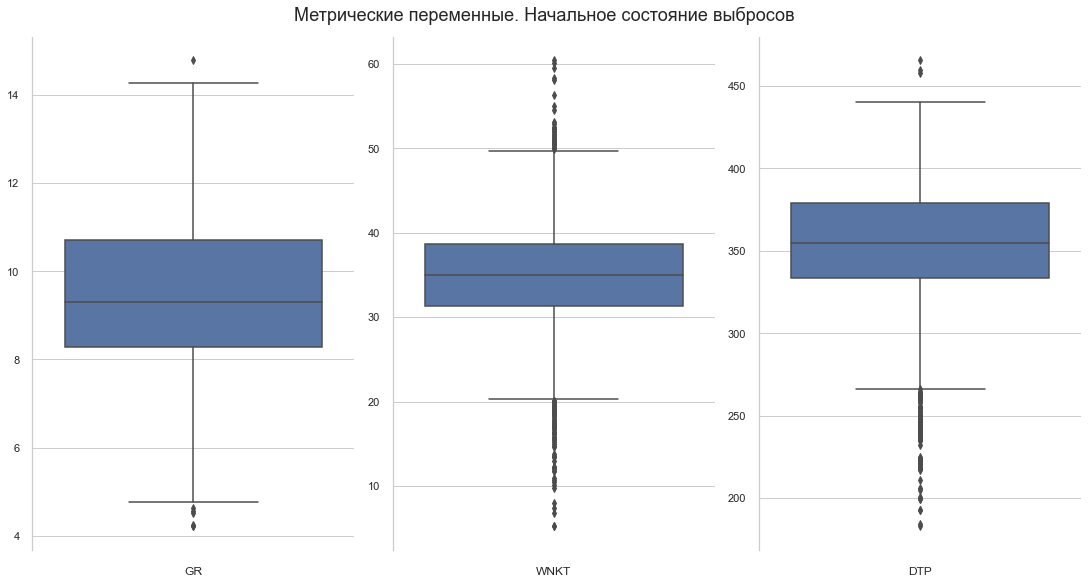

In [9]:
def plot_outliers(title, data):
    sns.set(style="whitegrid")

    # Prepare dataframe layout
    plot_features = list(data.columns)

    #Prepare figure layout
    fig, axes = plt.subplots(1, len(plot_features), figsize=(15,8), constrained_layout=True)

    # Draw the boxplots
    for i in zip(axes, plot_features):
        sns.boxplot(y=i[1], data=data[[i[1]]], ax=i[0])
        i[0].set_xlabel(i[1])
        i[0].set_ylabel("")

    # Finalize the plot
    plt.suptitle(title, fontsize=18)
    sns.despine(bottom=True)

    plt.show()

plot_outliers("Метрические переменные. Начальное состояние выбросов", metric_df)

In [10]:
yj = PowerTransformer(method='yeo-johnson')
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=np.random.RandomState(104))

X_trans_yj = yj.fit_transform(metric_df)
X_trans_qt = qt.fit_transform(metric_df)

# Merging
X_trans = np.concatenate((X_trans_yj, X_trans_qt), axis=1)

# Creating DataFrame
merge_labels = list(map(lambda x: "yj_" + x, metric_df.columns.to_list()))+list(map(lambda x: "qt_" + x,
                    metric_df.columns.to_list()))
trans_df = pd.DataFrame(X_trans, columns=merge_labels, index=metric_df.index)

In [11]:
transqt_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "qt" in i]]
transyj_df = trans_df.loc[:,[i for i in trans_df.columns.to_list() if "yj" in i]]

In [12]:
# outlier definition with IQR
def out_iqr(data, k=1.5, return_thresholds=False):
    # calculate interquartile range
    q25, q75 = np.percentile(data, 25, axis=0), np.percentile(data, 75, axis=0)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return data.apply(lambda x: np.any((x<lower) | (x>upper)), 1)

outlier_labels = pd.concat([out_iqr(transyj_df, 1.2), out_iqr(transqt_df, 1.2)], axis=1)

In [13]:
# multivariate Outliers (based on previous column-wise IQR)
def out_mahalanobis(data, random, contamination=0.03):
    n = data.shape[0]
    df = data.shape[1]
    # Obtain mahalanobis distance of each observation to the center and then sort it
    ee_out = cov.EllipticEnvelope(contamination=0.15, support_fraction=0.95, random_state=np.random.RandomState(304)).fit(data)
    mahalan = ee_out.mahalanobis(data)
    # Obtain chi-square percentiles of each observations
    quantiles = chi2.ppf(q=np.fromfunction(lambda x:(x-0.5)/n, (n,)), df=df)
    # Obtain labels
    labels = ee_out.predict(data)
    
    return mahalan, quantiles, labels

mqt, qqt, lqt = out_mahalanobis(transqt_df, 0)
myj, qyj, lyj = out_mahalanobis(transyj_df, 0)
lqt_lyj = pd.DataFrame({'lqt': lqt, 'lyj': lyj})

In [14]:
# checking outliers precentage
inl = lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1)].sum()['lqt']
'Outliers percentage: {:4.2f}%'.format(100 - inl/len(lqt_lyj) * 100)

'Outliers percentage: 17.02%'

In [15]:
# creating mask for outliers' drop
lqt_lyj.loc[(lqt_lyj['lqt'] == 1) & (lqt_lyj['lyj'] == 1), 'mask'] = True
lqt_lyj.fillna(False, inplace=True)
lqt_lyj.drop(columns=['lqt', 'lyj'], inplace=True)

In [16]:
# setting and duplicating mask
main_data = metric_df.merge(lqt_lyj, left_index=True, right_index=True)
try:
    cleaned_data = main_data.loc[main_data['mask'] == True].copy()  
except:
    print('Mask was not set')

In [17]:
# drop columns after outliers' definition in cleaned dataframe (without outliers)
cleaned_data.drop(columns=['mask'], inplace=True)

In [18]:
# defines number of deleted outliers
rows_after_iqr = len(cleaned_data)
print("Number of rows after outliers' deletition ", rows_after_iqr)
print("Deleted ", len(df) - len(cleaned_data), ' rows')

Number of rows after outliers' deletition  1492
Deleted  306  rows


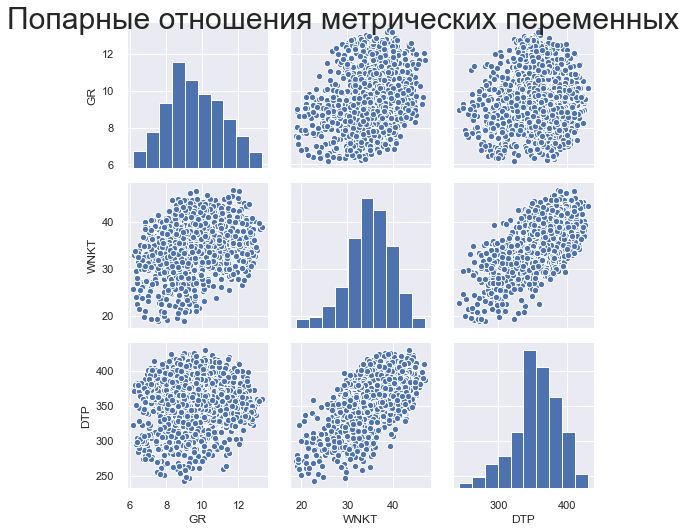

In [19]:
pairwise_rel(cleaned_data)

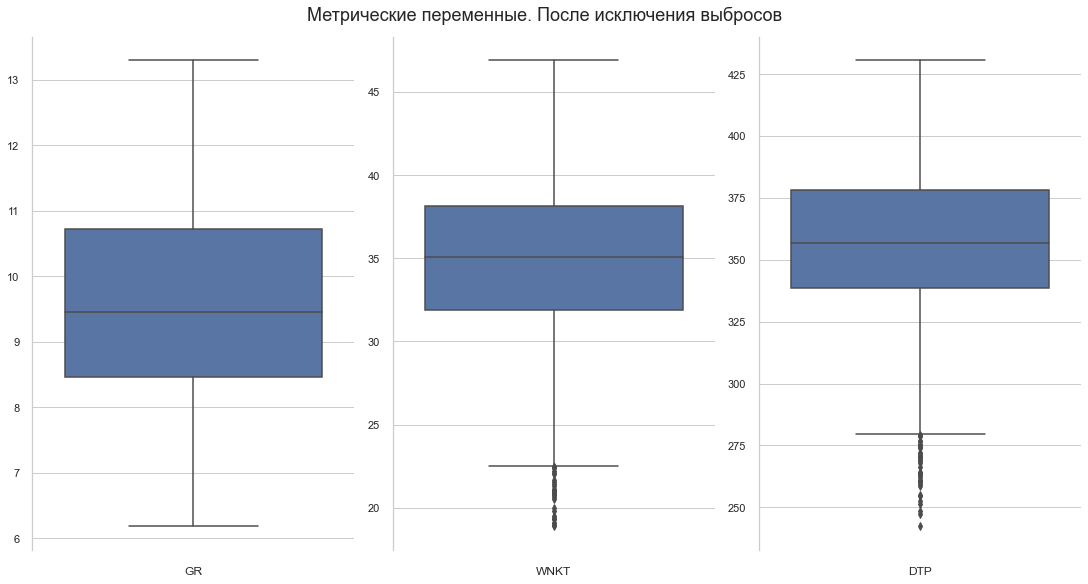

In [20]:
plot_outliers("Метрические переменные. После исключения выбросов", cleaned_data)

In [21]:
def plot_corr_matrix(metric_df, abs_apply=False, values=False, fig_size = (7, 7)):    
    sns.set(style="white")

    # Compute the correlation matrix
    corr = metric_df.corr() #Getting correlation of numerical variables
    if abs_apply == True:
        corr = corr.apply(np.abs)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
        
    # Draw the heatmap with the mask and correct aspect ratio
    if values:
        # Pass 2D Numpy array to annot parameter
        mask_annot = np.absolute(corr.values)>=0.70 # Annotate correlations above abs(0.7)
        annot_arr = np.where(mask_annot, corr.values.round(2), np.full(fig_size,""))
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax, annot=annot_arr, fmt="s")
    else:
        sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=25)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()

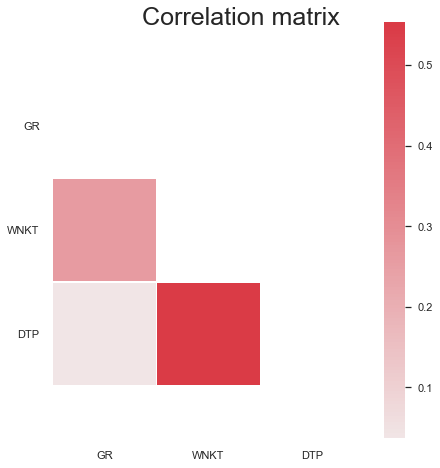

In [22]:
plot_corr_matrix(cleaned_data)

In [23]:
def kelbowplots(clus_estim, data):
    """
    This function produces the k-elbow plot for a given clustering estimator according to 3 different clustering quality measures: "Distortion", "Silhouette" and "Calinski Harabasz".
    """
    sns.set()
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    # Plot the data
    metrics = ["distortion", "silhouette", "calinski_harabasz"]
    ylabels = ["Distortion measure", "Silhouette measure", "Calinski Harabasz measure"]
    titles = ["Distortion measure plot", "Silhouette measure plot", "Calinski Harabasz measure plot"]
    for ax, m, yl, tl in zip(axes.flatten(), metrics, ylabels, titles):
        # KElbowVisualizer produces the elbow plot for several quality measures
        KElbowVisualizer(clus_estim, metric=m, timings=False, locate_elbow=False, ax=ax).fit(data)
        ax.invert_xaxis()
        ax.set_ylabel(yl, fontsize=13)
        ax.set_xlabel("Number of clusters", fontsize=13)
        ax.set_title(tl, fontsize=13)

    # Set figure
    plt.suptitle("K-Elbow Plots", fontsize=23)

    plt.show()

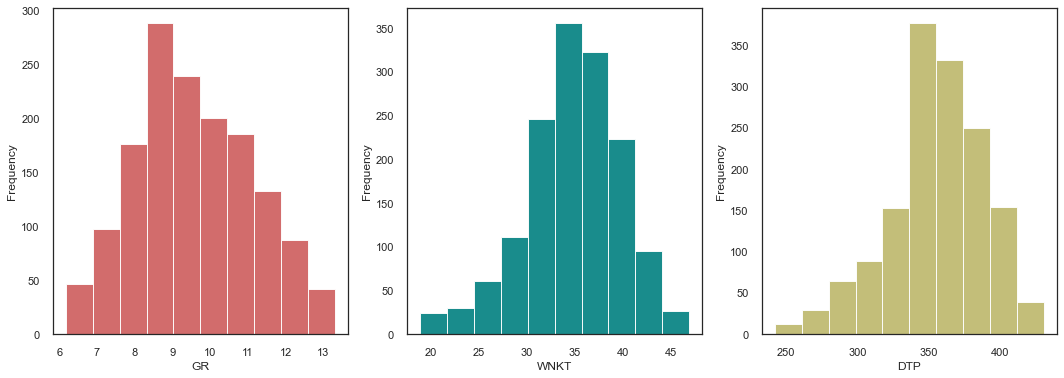

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
for col, ax, color in zip(cleaned_data, axes, ['indianred', 'teal', 'darkkhaki']):
    cleaned_data[col].plot.hist(ax=ax, alpha=0.9, color=color)
    ax.set_xlabel(col)
plt.show()

In [25]:
scaler = StandardScaler()
std_df = pd.DataFrame(scaler.fit_transform(cleaned_data), index=cleaned_data.index, columns=cleaned_data.columns)

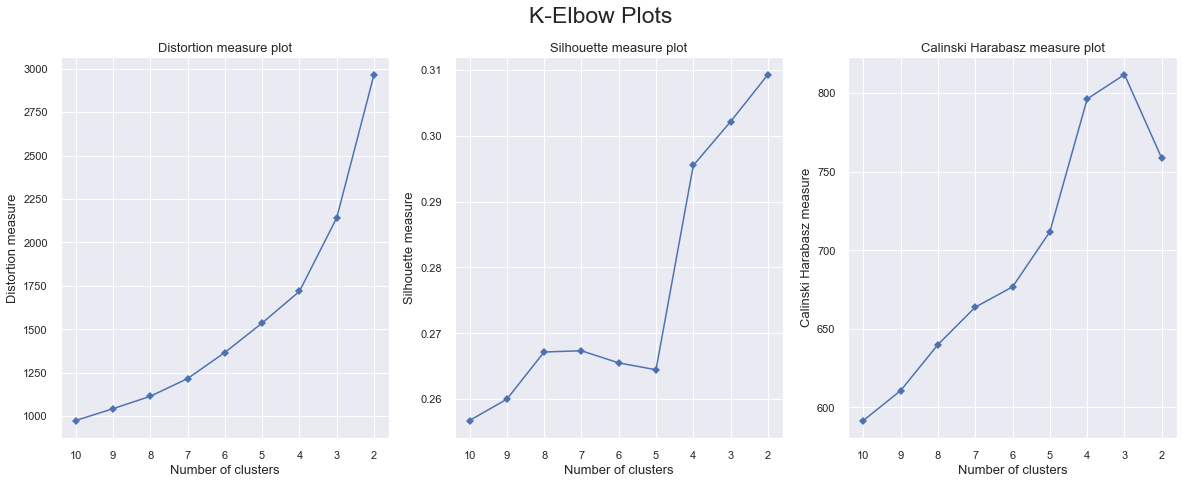

In [26]:
# инициализация K-Means модели
clus_estim = KMeans(random_state=0)

# построение K-elbow
kelbowplots(clus_estim, std_df)

In [27]:
# определение кластеров с использованием модели K-Means
def make_clusters(n_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
    df_res = std_df.copy()
    df_res['cluster'] = kmeans.fit_predict(np.array(std_df))
    return df_res

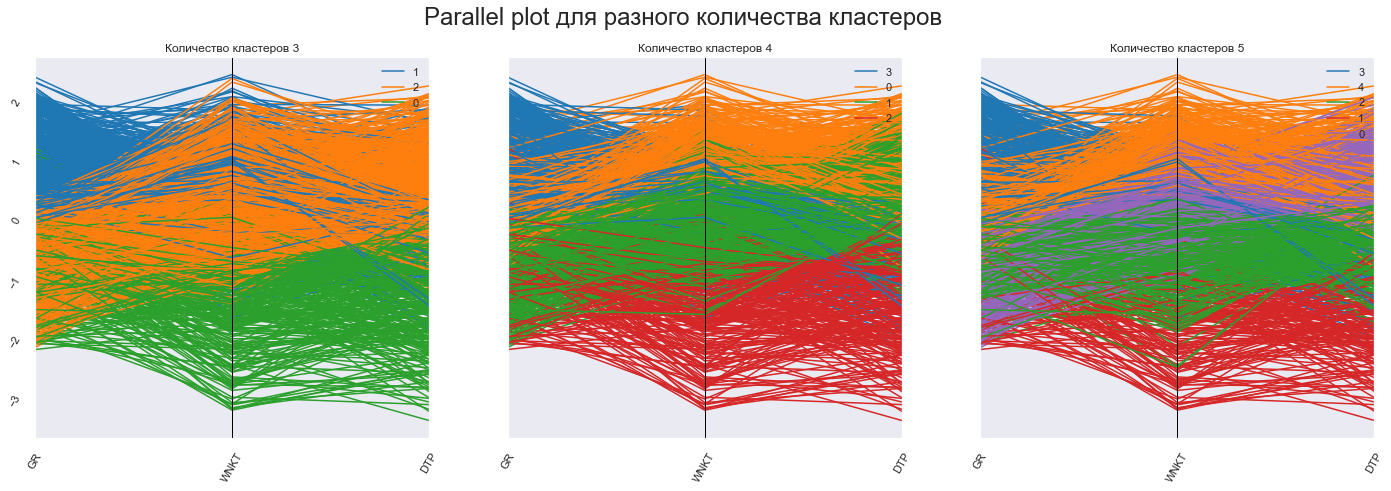

In [28]:
# parallel plot для разного количества кластеров
from matplotlib import colors as mcolors

f, axs = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(24, 7))
for i, ax in zip(range(3, 6), axs.flatten()):
    df_res = make_clusters(i)
    pd.plotting.parallel_coordinates(df_res, 'cluster', color=list(mcolors.TABLEAU_COLORS.values()), ax=ax)
    ax.tick_params(labelrotation=60)
    ax.set_title('Количество кластеров ' + str(i))

plt.suptitle("Parallel plot для разного количества кластеров", fontsize=24)
plt.show()

In [29]:
#K means кластеризация
def doKmeans(df, nclust):
    model = KMeans(nclust, random_state=0)
    model.fit(df)
    clust_labels = model.predict(df)
    cent = model.cluster_centers_
    return (clust_labels, cent)

In [30]:
# кластеризация с использованием K-Means в 4 кластера
clust_labels, cent = doKmeans(std_df, 4)
kmeans_std_df = std_df.copy()
kmeans_std_df["kmeans_labels"] = clust_labels

X = np.array(std_df)

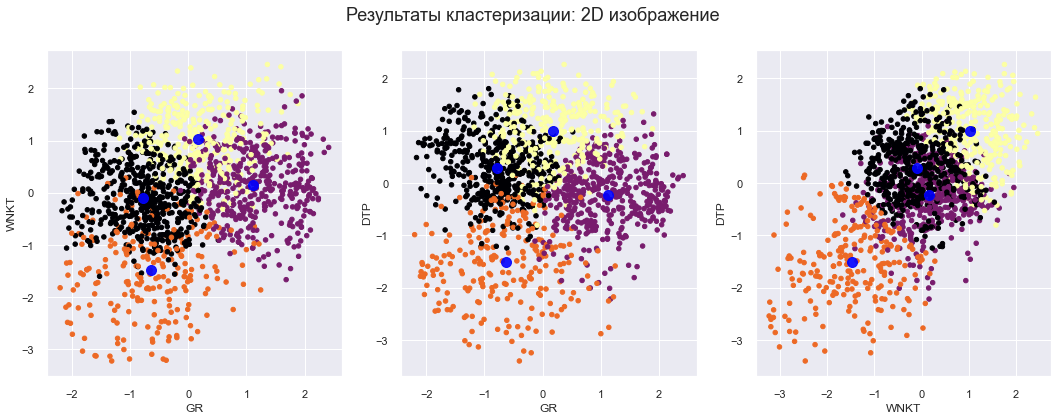

In [31]:
# scatter plot для полученной кластеризации
from itertools import combinations
pairs = combinations(std_df, 2)

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, var_pair in zip(axes, pairs):
    ax.scatter(std_df[var_pair[0]], std_df[var_pair[1]], c = clust_labels, s = 20, cmap = 'inferno')
    ax.scatter(cent.T[list(std_df.columns).index(var_pair[0])], cent.T[list(std_df.columns).index(var_pair[1])],
               c = 'blue', s = 100, alpha = 0.9)
    ax.set_xlabel(var_pair[0])
    ax.set_ylabel(var_pair[1])
plt.suptitle('Результаты кластеризации: 2D изображение', fontsize=18)
plt.show()

In [32]:
cleaned_data['cluster'] = clust_labels
clusterized = cleaned_data.merge(df[['well_id', 'TVD', 'id']], left_index=True, right_on='id')

In [33]:
clusterized.head(5)

,GR,WNKT,DTP,cluster,well_id,TVD,id
0,10.257,40.069,343.124,1,UZ-12,842.031,0
1,9.947,40.314,339.601,1,UZ-12,842.130,1
2,9.366,40.060,340.717,3,UZ-12,842.228,2
3,8.050,38.385,331.685,0,UZ-12,842.327,3
4,6.654,34.709,308.736,2,UZ-12,842.426,4


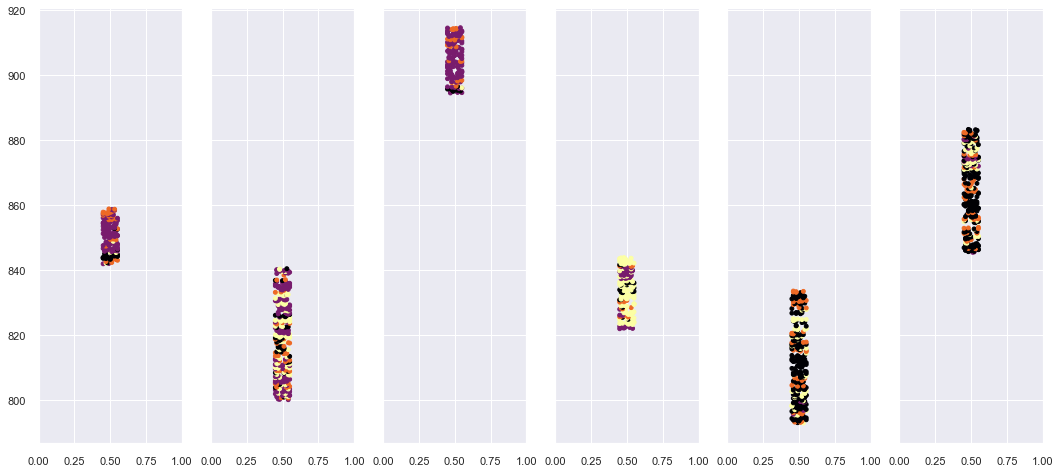

In [56]:
n_plots = clusterized.well_id.nunique()
n_rows = int(np.ceil(n_plots / 6))

fig, axes = plt.subplots(n_rows, 6, figsize=(18, 8 * n_rows), sharey=True)
for well, ax in zip(clusterized.well_id.unique(), axes.flatten()):
    df_well = clusterized.loc[clusterized.well_id == well].copy()
    df_well['x_coord'] = 1
    df_well.x_coord = df_well['x_coord'].apply(lambda x: x * randint(45, 55) / 100)
    ax.scatter(df_well.x_coord, df_well.TVD, c=df_well.cluster, s=15, cmap='inferno')
    ax.set_xlim([0, 1])
    